In [1]:
! pip install -q kaggle --upgrade #OS에 리눅스 명령
from google.colab import files


! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! kaggle competitions download -c competitive-data-science-predict-future-sales

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-08 07:43:38            110  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            116  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            234  
nickuzmenkov/ranzcr-clip-kfold-tfrecords                    RANZCR CLiP KFold TFRecords                         2GB  2021-02-21 13:29:51             12  
landrykezebou/lvzhdr-tone-mapping-benchmark-dataset-tmonet  LVZ-HDR Tone Map

In [2]:
! unzip items.csv.zip -d ./
! unzip sales_train.csv.zip -d ./
! unzip sample_submission.csv.zip -d ./
! unzip test.csv.zip -d ./

Archive:  items.csv.zip
  inflating: ./items.csv             
Archive:  sales_train.csv.zip
  inflating: ./sales_train.csv       
Archive:  sample_submission.csv.zip
  inflating: ./sample_submission.csv  
Archive:  test.csv.zip
  inflating: ./test.csv              


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):
  flg, ax = plt.subplots(1, 1, figsize=figsize)
  return plot_importance(booster=booster, ax=ax)


import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)

In [22]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv').set_index('ID')

In [20]:
test = pd.read_csv('test.csv').set_index('ID')

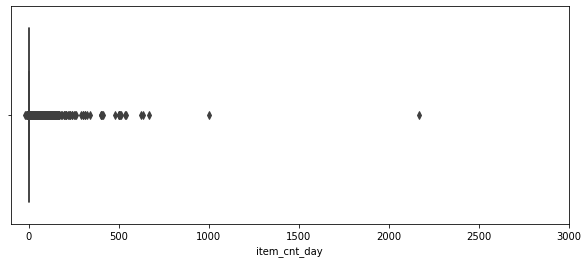

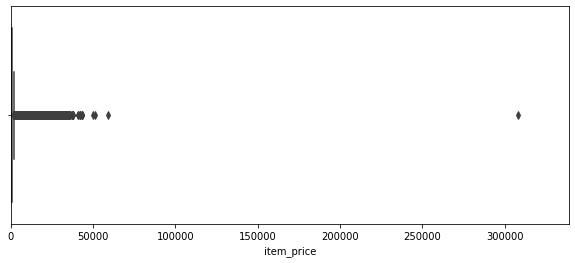

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [23]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

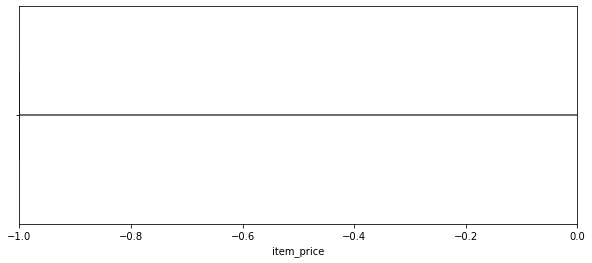

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), 0)
sns.boxplot(x=train.item_price)

In [24]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [25]:
train.loc[train.shop_id==0, 'shop_id'] = 57
test.loc[train.shop_id==0, 'shop_id'] = 57

train.loc[train.shop_id==1, 'shop_id'] = 58
test.loc[train.shop_id==1, 'shop_id'] = 58

train.loc[train.shop_id==10, 'shop_id'] = 11
test.loc[train.shop_id==10, 'shop_id'] = 11

In [14]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [26]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]

In [17]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [27]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [28]:
items.drop(['item_name'], axis=1, inplace=True)

In [21]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [22]:
#train에는 없고 test에만 존재, test존재 상품 수, 테스트 데이터셋 크기
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [34]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

14.478020429611206

In [24]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [35]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

3.877052068710327

In [26]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [36]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [37]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08358216285705566

In [29]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [30]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


In [38]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.4840526580810547

In [32]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [33]:
def lag_feature(df, lags, col):
    """
    이전 달의 feature 들을, 현재 월의 feature 로 둡니다.
    이 떄, 이전 달들의 정보는 lags 에,
    사용할 feature 들은 col 에 담겨져 있습니다.
    """
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [34]:
ts = time.time()
# 1,2,3,6,12 달 전의 item_cnt_month 값을, 현재 해당 월의 feature 로 둡니다.
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

29.071453332901

In [35]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [36]:
# 해당 월에, 일반적으로 상품들이 팔린 평균 개수 (즉, 월 단위로 같음.) 과 레그.
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.527193307876587

In [37]:
# 해당 월에, 각각의 상품 단위로, 팔린 상품 갯수의 평균 (즉, (월, 상품) 단위) 와 레그.
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.08903503417969

In [38]:
# 해당 월에, 각각의 상점 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

40.21825981140137

In [39]:
# 해당 월에, 각각의 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.657891273498535

In [40]:
# 해당 월에, 각각의 상점에서, 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.465195655822754

In [41]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입1) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.73062515258789

In [42]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입2) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.170294523239136

In [43]:
# 해당 월에, 도시 단위로 팔린 상품 갯수의 평균과 레그 (월, 도시) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.30104947090149

In [44]:
# 해당 월에, 각각 아이템, 도시 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템, 도시) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.632492303848267

In [45]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입1) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.55892324447632

In [46]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입2) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.832883596420288

In [47]:
ts = time.time()

# 전 기간동안의 각각 상품의 평균 가격. (상품) 단위.
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# 월별 상품 평균 가격. (월, 상품) 단위.
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# 월별, 각 1~6개월 전의 평균 가격 (월, 상품) 단위.
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# 월별, 각 1~6개월 전의 평균 가격과 전 기간 평균 가격과의 차이. (월, 상품) 단위.
# 전 구간 가격 평균하고 1~6달 가격을 비교함으로써, 지난 1~6달간의 가격 트랜드를 알 수 있음.
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# 현재 달 기준, 지난 1~6달 중, 최근의 트랜드를 찾음.
# 가장 최근 1달 전이 좋지만, 없을 경우 최대 6달 전까지 찾는 것.
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# feature drop 하기
# 가장 최근 price trend 를 찾았으니, 가격과 관련된 이전 lags 들은 필요 없음.
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

185.53083515167236

In [48]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [49]:
# 가격 트랜드와 동일하게, 총 수입 트랜드도 잡아봄.
# 가격 트랜드 방법과 똑같음.

ts = time.time()

# 월별 각각의 상점 총 매출. (월, 상점) 단위.
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 전 기간동안, 각각의 상점 매출 평균. (상점) 단위.
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# 각각 상점의 월평균 매출 - 전기간 평균매출 의 차이. (월, 상점) 단위.
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# 가장 최근 한 달전의 총 매출만 사용.
matrix = lag_feature(matrix, [1], 'delta_revenue')

# 최근 총매출 트랜드를 얻었으니, 필요없는 Feature들 다시 삭제.
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

21.22471332550049

In [50]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [51]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

# (상점, 상품)단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_shop_last_sale 에 저장.
# 예를 들어 1달 전에 팔렸으면 1임.
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

878.7185413837433

In [52]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

# (상품) 단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_last_sale 에 저장.
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

581.2142605781555

In [53]:
ts = time.time()

matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.2311429977416992

In [54]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.4113013744354248

In [55]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

2.172105312347412

In [39]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code'],
      dtype='object')

In [40]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    float16
 4   city_code         int8   
 5   item_category_id  int8   
 6   type_code         int8   
 7   subtype_code      int8   
dtypes: float16(1), int16(1), int8(6)
memory usage: 191.0 MB


In [41]:
matrix.to_pickle('data_n.pkl')

In [42]:

del matrix
#del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [43]:
data = pd.read_pickle('/content/drive/MyDrive/data_n.pkl')

In [44]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [45]:
del data
gc.collect();

In [46]:
def objective(trial,data=X_train,target=Y_train):
  
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBRegressor(**param, objective='reg:squarederror')  
    
    model.fit(X_train,Y_train,eval_set=[(X_valid,Y_valid)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_valid)
    
    rmse = mean_squared_error(Y_valid, preds,squared=False)
    
    return rmse

In [47]:
!pip install optuna
import optuna
from optuna import Trial, visualization

     |████████████████████████████████| 296kB 19.6MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 163kB 57.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 143kB 57.8MB/s 
     |████████████████████████████████| 112kB 39.7MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=689632a2680fc37993315d5f5d58c2b21c05092a51f89f9a9533b03bb62b2b8b
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-08 10:49:55,245] A new study created in memory with name: no-name-bc7d32f1-2331-4a5c-9025-07c137c233a6
[I 2021-03-08 10:50:45,082] Trial 0 finished with value: 1.032942533493042 and parameters: {'lambda': 0.1330059520531632, 'alpha': 1.0677732011403198, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 36}. Best is trial 0 with value: 1.032942533493042.
[I 2021-03-08 10:52:03,070] Trial 1 finished with value: 0.9977468848228455 and parameters: {'lambda': 0.001259423073861956, 'alpha': 0.011975195653501554, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 127}. Best is trial 1 with value: 0.9977468848228455.
[I 2021-03-08 10:52:16,170] Trial 2 finished with value: 1.0789377689361572 and parameters: {'lambda': 0.09899495007181211, 'alpha': 0.002280288847835971, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n

Number of finished trials: 25
Best trial: {'lambda': 0.0028604903355720105, 'alpha': 0.14432047497533834, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 3000, 'max_depth': 11, 'min_child_weight': 28}


In [11]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.914802,2021-03-04 16:10:32.310388,2021-03-04 16:14:25.262230,0 days 00:03:52.951842,0.045229,0.5,1.993809,0.010,4,211,3000,0.8,COMPLETE
1,1,0.900533,2021-03-04 16:14:25.263994,2021-03-04 16:15:45.498326,0 days 00:01:20.234332,0.005477,0.7,0.580335,0.018,15,112,200,0.7,COMPLETE
2,2,0.903841,2021-03-04 16:15:45.499751,2021-03-04 16:16:36.105962,0 days 00:00:50.606211,1.128180,0.9,0.868682,0.018,13,77,150,0.8,COMPLETE
3,3,0.904817,2021-03-04 16:16:36.107453,2021-03-04 16:18:55.591364,0 days 00:02:19.483911,0.011069,0.9,0.021592,0.008,15,208,3000,1.0,COMPLETE
4,4,0.900455,2021-03-04 16:18:55.592935,2021-03-04 16:20:36.089185,0 days 00:01:40.496250,0.045389,0.7,0.005180,0.009,13,229,3000,0.7,COMPLETE


In [49]:
study.best_params

{'alpha': 0.14432047497533834,
 'colsample_bytree': 0.8,
 'lambda': 0.0028604903355720105,
 'learning_rate': 0.016,
 'max_depth': 11,
 'min_child_weight': 28,
 'n_estimators': 3000,
 'subsample': 0.6}

In [53]:
best_params = study.best_params
best_params['tree_method'] = 'gpu_hist'
best_params['random_state'] = 42

clf = XGBRegressor(**(best_params), objective='reg:squarederror')

clf.fit(X_train, 
    Y_train)

XGBRegressor(alpha=0.14432047497533834, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             gamma=0, importance_type='gain', lambda=0.0028604903355720105,
             learning_rate=0.016, max_delta_step=0, max_depth=11,
             min_child_weight=28, missing=None, n_estimators=3000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='gpu_hist', verbosity=1)

In [52]:
ts = time.time()

model = XGBRegressor(
    alpha=0.03244039167530487, base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
    gamma=0, gpu_id=0, importance_type='gain',
    interaction_constraints='',
    learning_rate=0.009, max_delta_step=0, max_depth=17,
    min_child_weight=249,
    monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
    reg_alpha=0.0324403904, reg_lambda=0.00100399321,
    scale_pos_weight=1, subsample=0.7, tree_method='gpu_hist',
    validate_parameters=1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

KeyboardInterrupt: ignored

In [54]:
Y_pred = clf.predict(X_valid).clip(0, 20)
Y_test = clf.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission3.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [14]:
X_test.head()

,date_block_num,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
10913804,34,5,5037,3,19,5,10,0.0,1.0,3.0,1.0,1.0,0.258545,0.568359,2.511719,2.833984,1.977539,1.299805,0.190063,0.205933,0.245117,0.180054,0.206055,0.379150,0.513672,0.456055,0.447021,0.190063,0.0,0.494141,0.337402,-0.222046,-0.048553,10,30,1,1,14,14
10913805,34,5,5320,3,55,13,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,10,30,-1,-1,0,0
10913806,34,5,5233,3,19,5,10,1.0,3.0,1.0,3.0,0.0,0.258545,0.954590,1.860352,3.572266,1.613281,0.000000,0.190063,0.205933,0.245117,0.180054,0.000000,0.379150,0.513672,0.456055,0.447021,0.190063,1.0,0.494141,0.337402,0.496826,-0.048553,10,30,1,1,7,7
10913807,34,5,5232,3,23,5,16,0.0,0.0,1.0,0.0,0.0,0.258545,0.636230,1.116211,1.547852,0.000000,0.000000,0.190063,0.205933,0.245117,0.000000,0.000000,0.337402,0.374268,0.456055,0.349121,0.190063,0.0,0.494141,0.331787,0.505371,-0.048553,10,30,1,1,3,3
10913808,34,5,5268,3,20,5,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,10,30,-1,-1,0,0


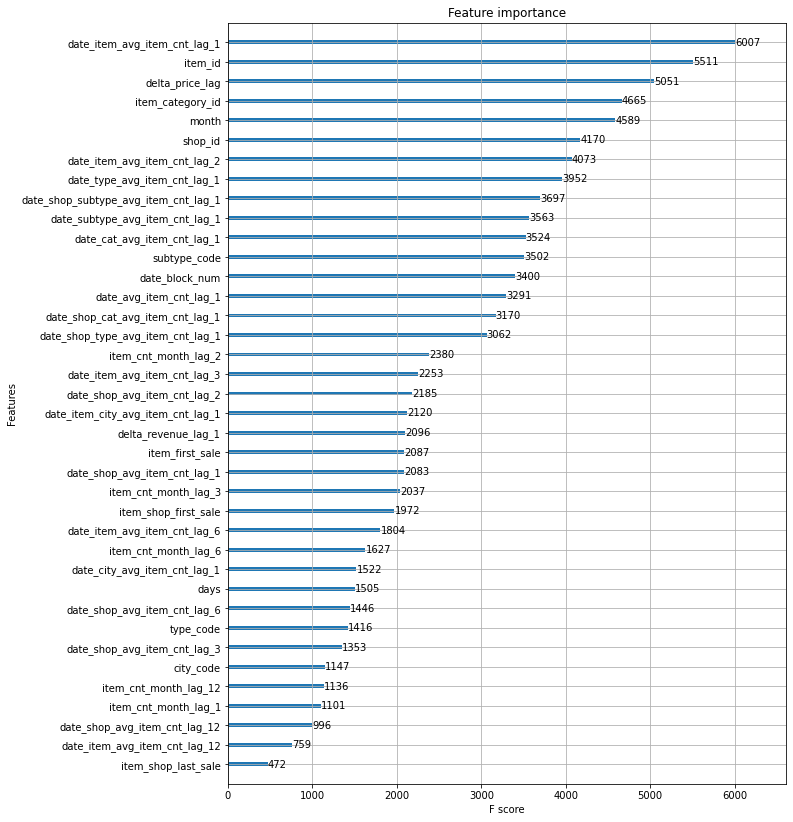

In [25]:
plot_features(clf, (10,14))